In [ ]:
!pip install torch==2.0.1
!pip install transformers
!pip install accelerate
!pip install datasets[audio]
!pip install evaluate
!pip install jiwer
!pip install intel_extension_for_pytorch==2.0.100

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.3 MB/s eta 0:00:00


In [ ]:
!export ONEDNN_MAX_CPU_ISA="AVX512_CORE_AMX"

In [ ]:
!pip install rouge

In [ ]:
import numpy as np
import torch
import transformers
import datasets
import librosa
import re
import json
import random
import matplotlib.pyplot as plt
import pandas as pd
import evaluate
import nltk
import librosa.display

from datasets import load_dataset, load_metric, ClassLabel, Audio
from transformers import WhisperConfig, WhisperProcessor, WhisperFeatureExtractor, WhisperTokenizer, WhisperForConditionalGeneration
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding, DataCollator
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, Trainer, TrainingArguments
from transformers import pipeline
from transformers.utils import send_example_telemetry

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
from transformers import AdamW
from datasets import DatasetDict
from datasets import concatenate_datasets
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!huggingface-cli download PolyAI/minds14 --repo-type dataset --revision refs/convert/parquet --local-dir . --local-dir-use-symlinks False  --include 'en-US/*'

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
Fetching 1 files:   0% 0/1 [00:00<?, ?it/s]downloading https://huggingface.co/datasets/PolyAI/minds14/resolve/eccc1d790caefb22ddbdbdd568aa5867c5a3aa00/en-US/train/0000.parquet to /root/.cache/huggingface/hub/tmp5jey6d4p

0000.parquet:   0% 0.00/34.2M [00:00<?, ?B/s]
0000.parquet: 100% 34.2M/34.2M [00:00<00:00, 209MB/s]
Fetching 1 files: 100% 1/1 [00:00<00:00,  1.72it/s]
/content


In [ ]:
minds_enUS = load_dataset('./en-US', split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
print(minds_enUS)

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 563
})


In [ ]:
intent_classes = [
    {'index': 0, 'name': 'abroad'},
    {'index': 1, 'name': 'adress'},
    {'index': 2, 'name': 'app_error'},
    {'index': 3, 'name': 'atm_limit'},
    {'index': 4, 'name': 'balance'},
    {'index': 5, 'name': 'business_loan'},
    {'index': 6, 'name': 'card_issues'},
    {'index': 7, 'name': 'cash_deposite'},
    {'index': 8, 'name': 'direct_debit'},
    {'index': 9, 'name': 'freeze'},
    {'index': 10, 'name': 'latest_transactions'},
    {'index': 11, 'name': 'joint_account'},
    {'index': 12, 'name': 'high_value_payment'},
    {'index': 13, 'name': 'pay_bill'}
]

def plot_label_distribution(dataset):
    # Extract intent_class labels
    labels = dataset['intent_class']

    # Count the frequency of each label
    label_counts = {}
    for label in labels:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

    # Sort labels by their counts in descending order
    sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_labels = [{'name': intent_classes[label[0]]['name'], 'index': intent_classes[label[0]]['index'], 'count': label[1]} for label in sorted_labels]

    # Create x-axis labels combining name and index
    x_labels = [f"{label['name']} ({label['index']})" for label in sorted_labels]
    counts = [label['count'] for label in sorted_labels]

    # Plot distribution
    plt.figure(figsize=(12, 6))
    plt.bar(x_labels, counts, color='skyblue')
    plt.xlabel('Intent Class')
    plt.ylabel('Frequency')
    plt.title('Distribution of Intent Classes')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

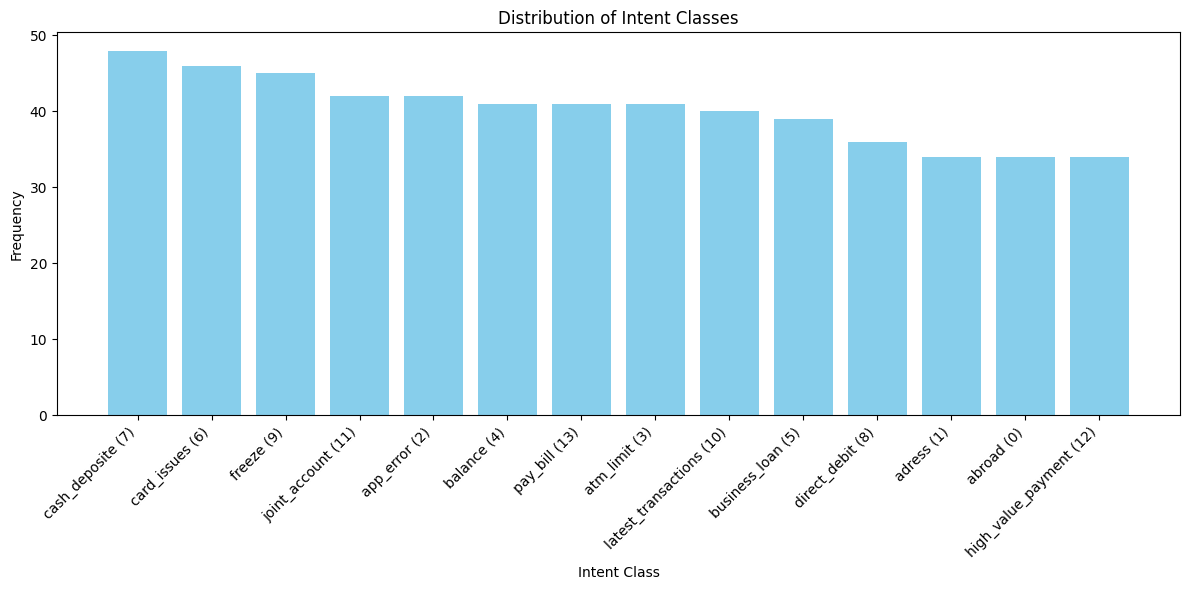

In [ ]:
plot_label_distribution(minds_enUS)

In [ ]:
import IPython.display as ipd
from IPython.core.display import display

def plot_waveform_and_spectrogram(dataset, intent_class, name_intent):
    # Filter dataset for a specific intent_class
    filtered_data = dataset.filter(lambda example: example['intent_class'] == intent_class)

    # Take the first audio sample for the given intent_class
    sample = filtered_data[0]

    # Extract audio array and sampling rate
    audio_array = sample['audio']['array']
    sr = sample['audio']['sampling_rate']

    # display(Audio(sample['audio']))
    ipd.Audio(data=np.asarray(sample['audio']['array']), rate=8000)

    print("transcription: ", sample['transcription'])

    # Plot Waveform
    plt.figure(figsize=(20, 8))

    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    librosa.display.waveshow(audio_array, sr=sr)
    plt.title(f'Waveform for intent_class: {intent_class} {name_intent}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    # Compute and plot Spectrogram
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    X = librosa.stft(audio_array)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title(f'Spectrogram for intent_class: {intent_class} {name_intent}')

    plt.tight_layout()
    plt.show()


Filter:   0%|          | 0/563 [00:00<?, ? examples/s]

transcription:  yes I'm going to be traveling to the United Kingdom for a couple of weeks next month I need to know if I can use my card from from my bank account while I'm in Europe


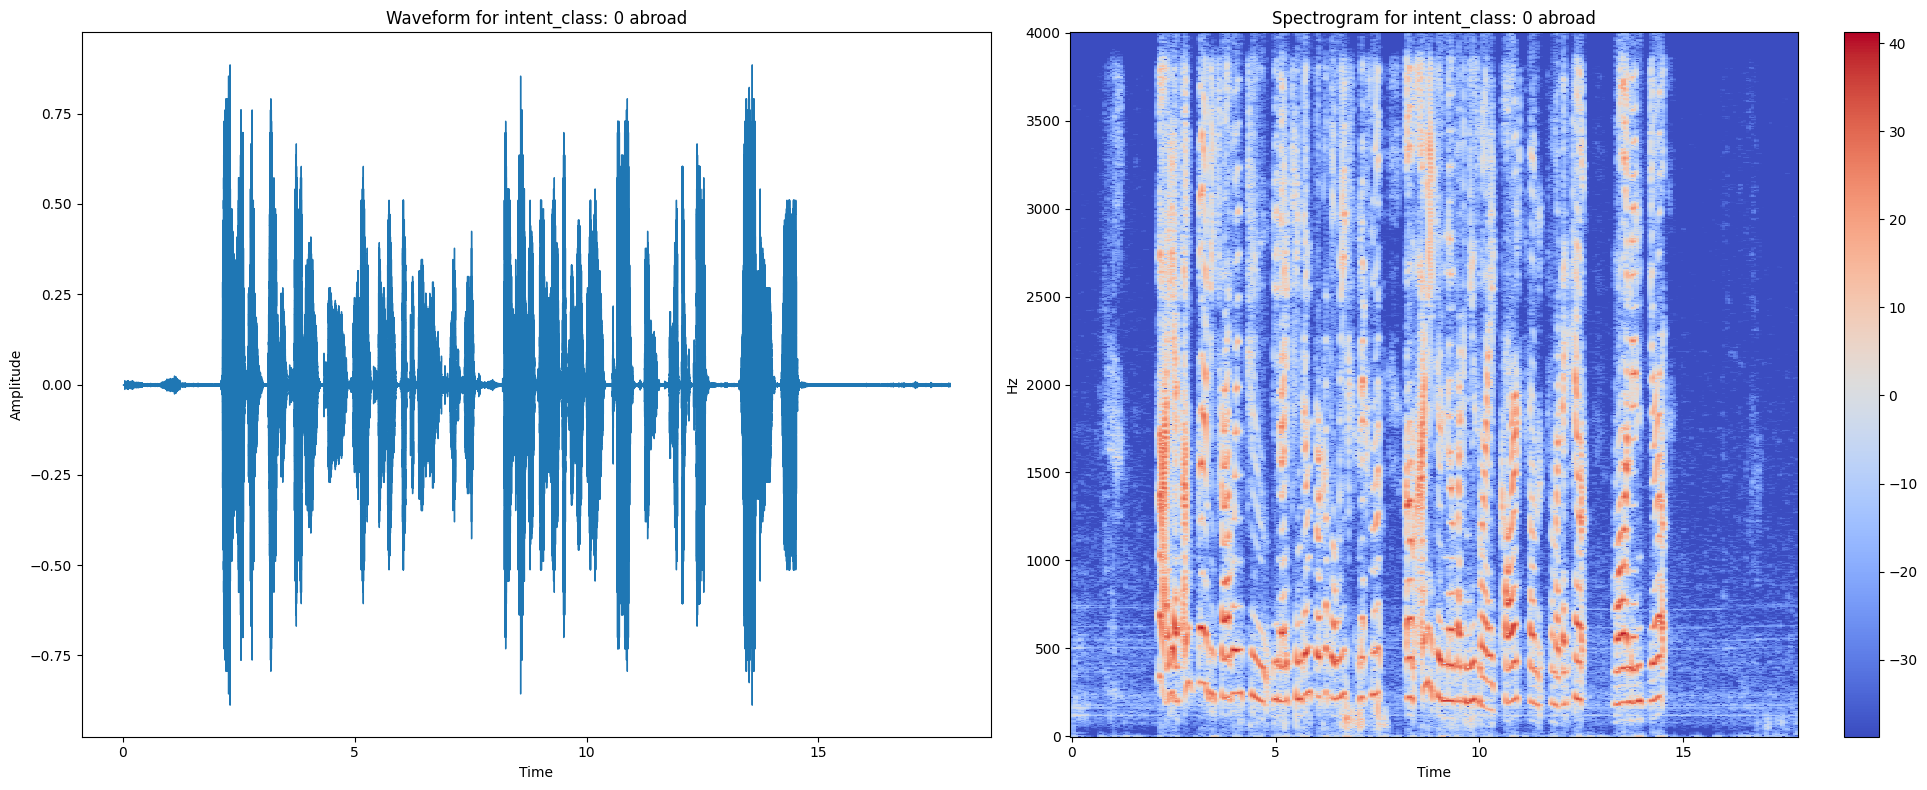

Filter:   0%|          | 0/563 [00:00<?, ? examples/s]

transcription:  hi yes I like to change my address


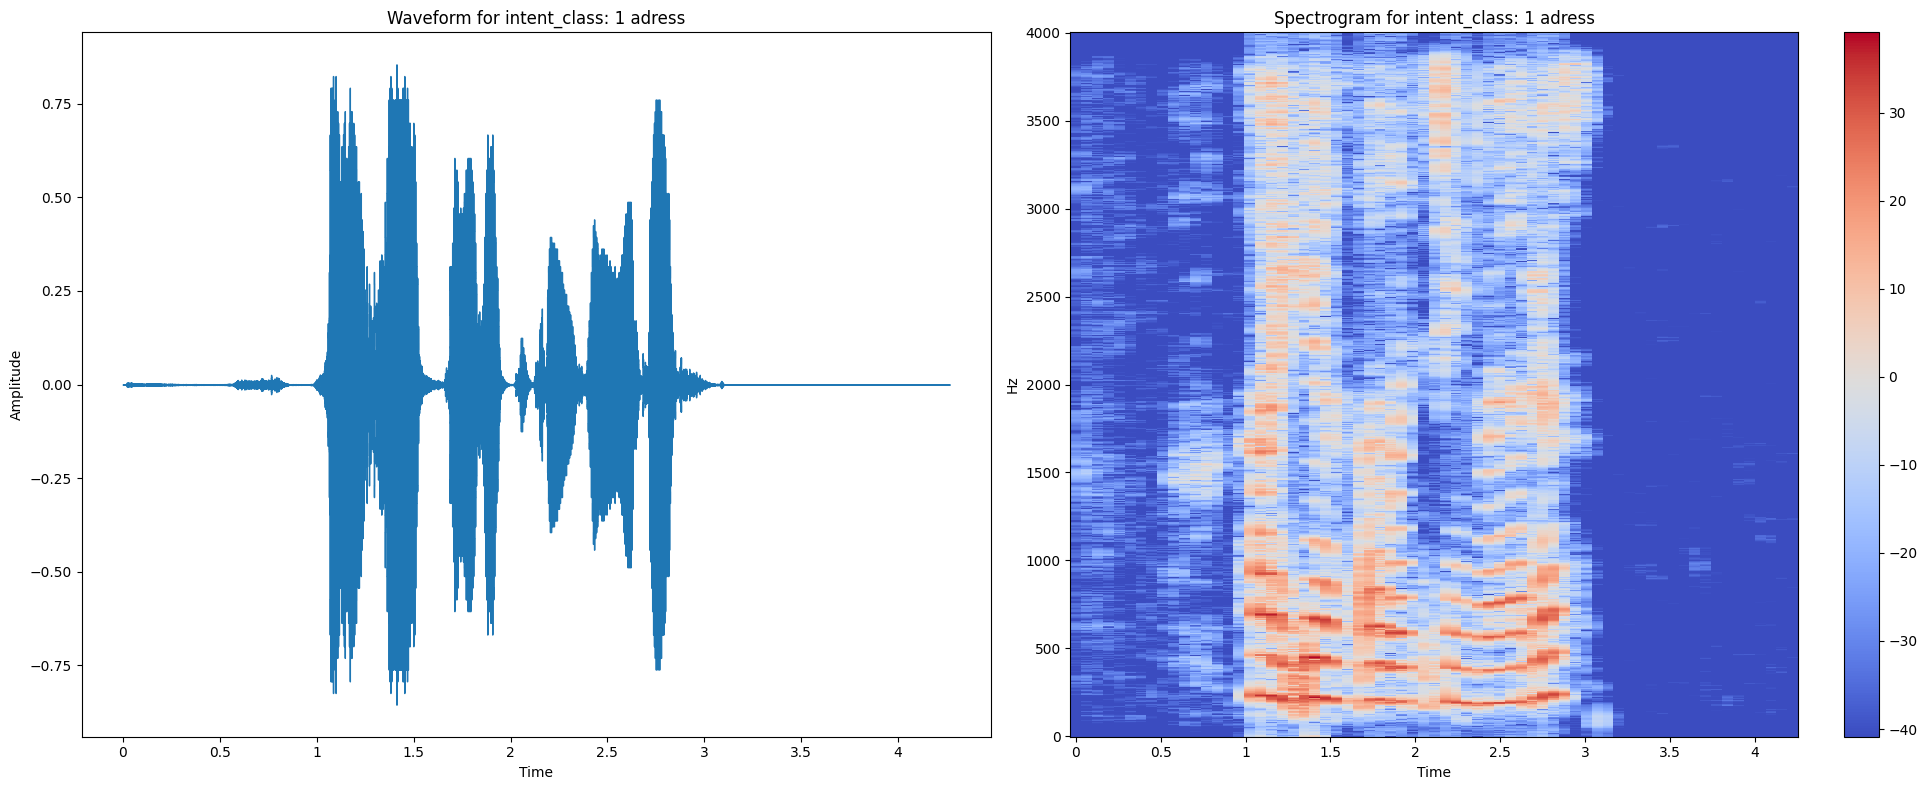

Filter:   0%|          | 0/563 [00:00<?, ? examples/s]

transcription:  high on the app isn't loading information


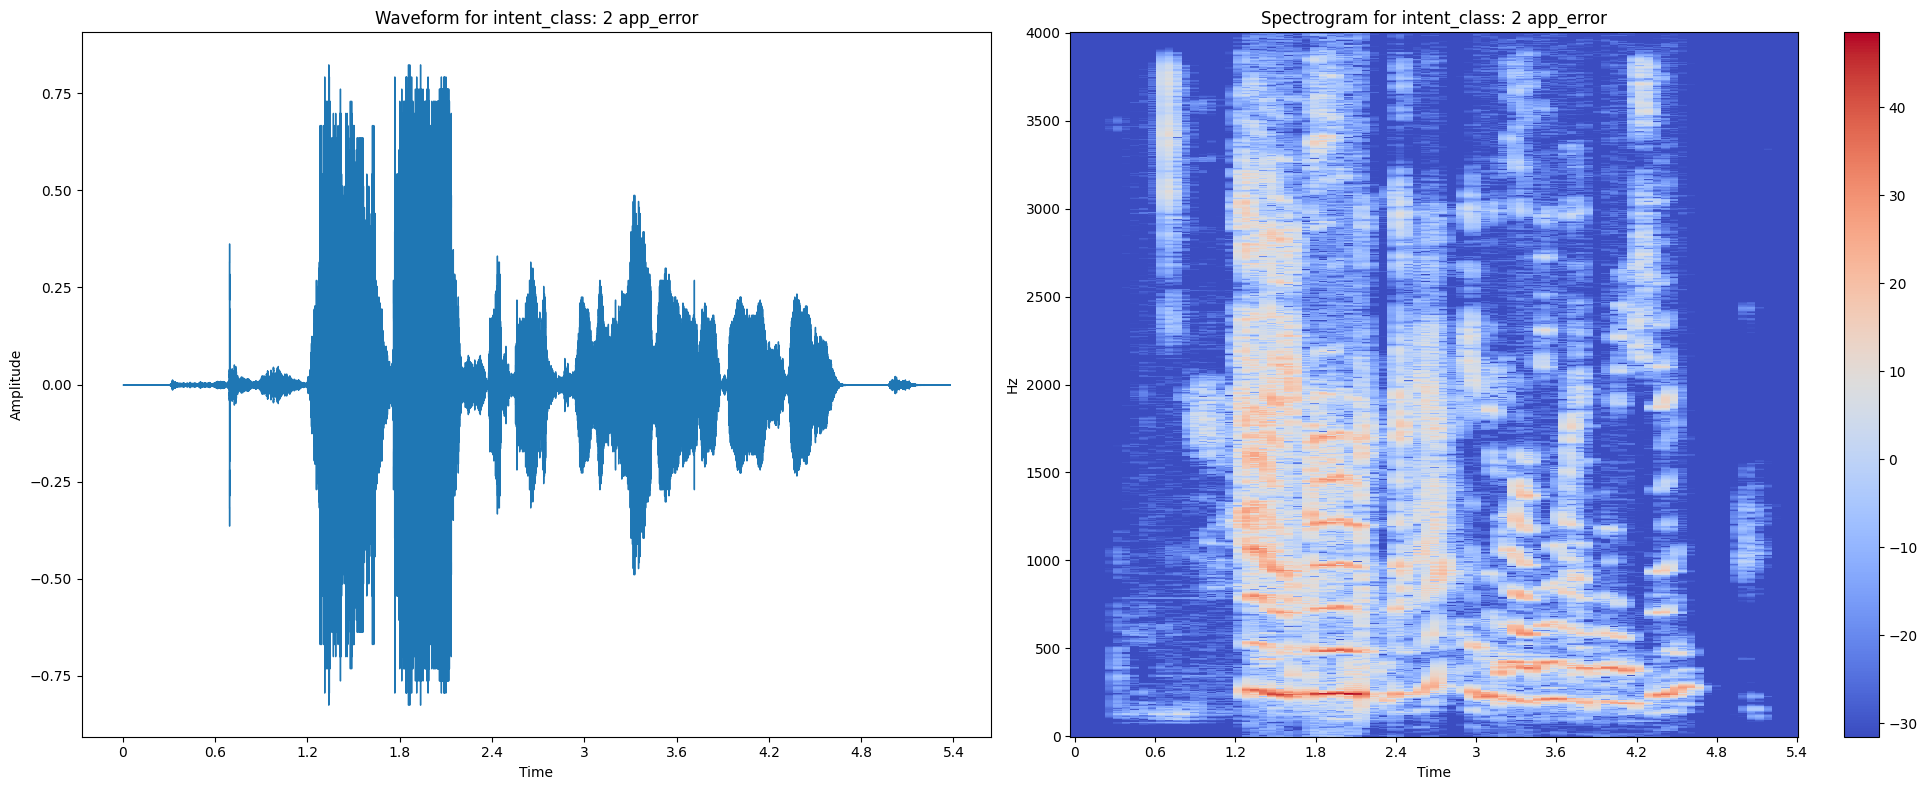

Filter:   0%|          | 0/563 [00:00<?, ? examples/s]

transcription:  how much money can I withdraw per day from the ATM


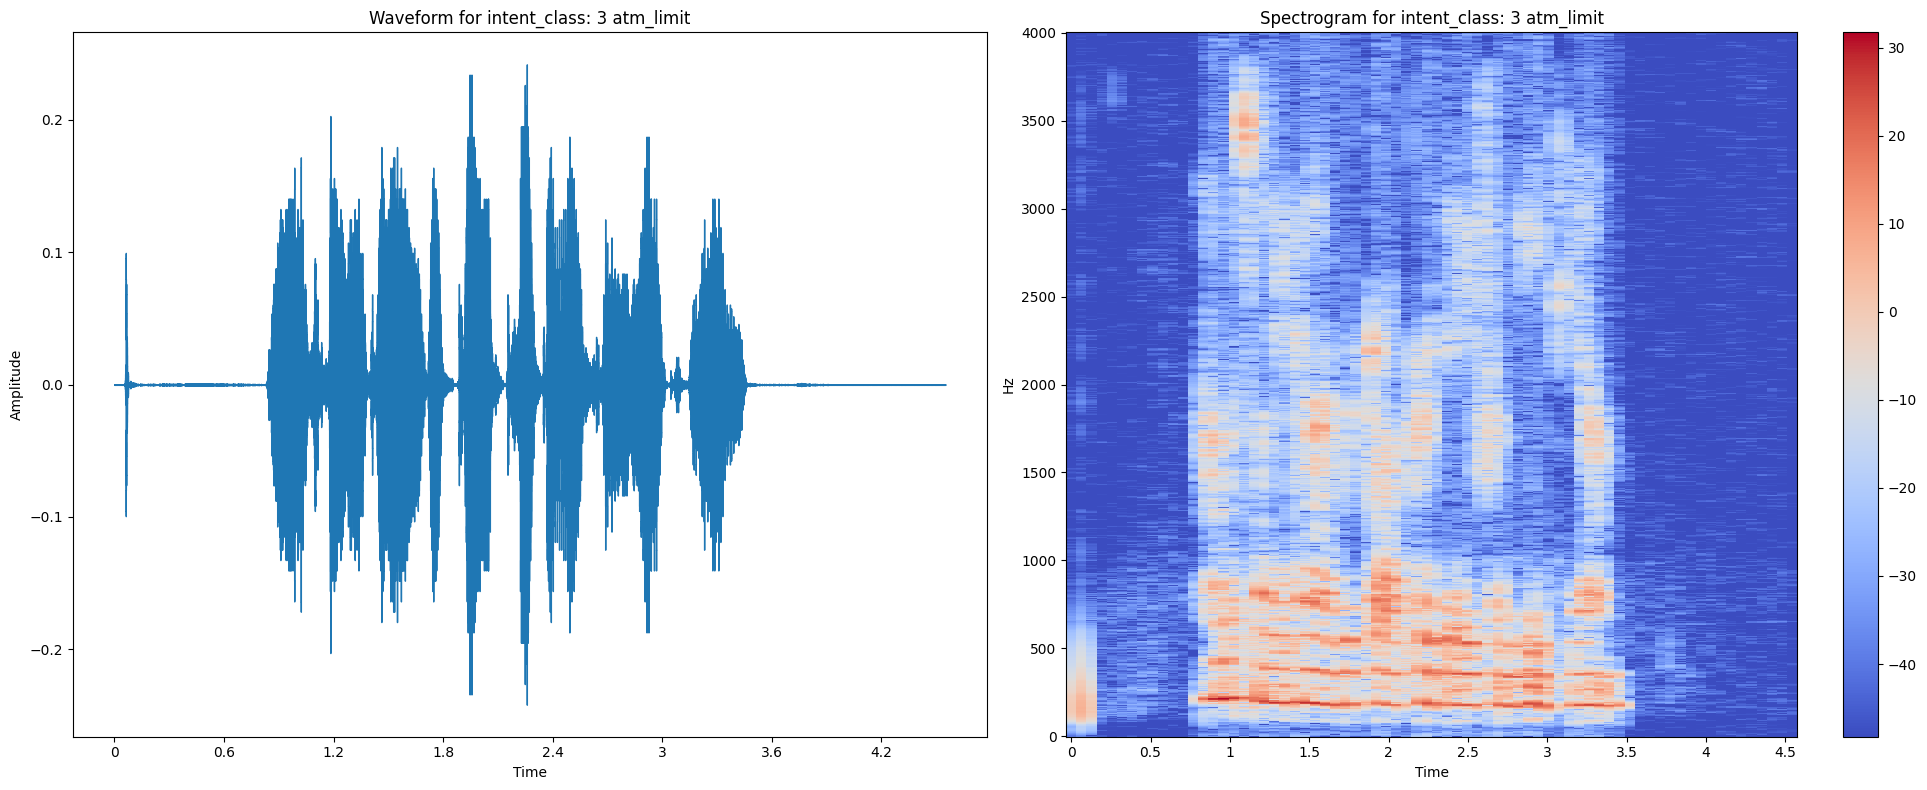

Filter:   0%|          | 0/563 [00:00<?, ? examples/s]

transcription:  what is my account balance


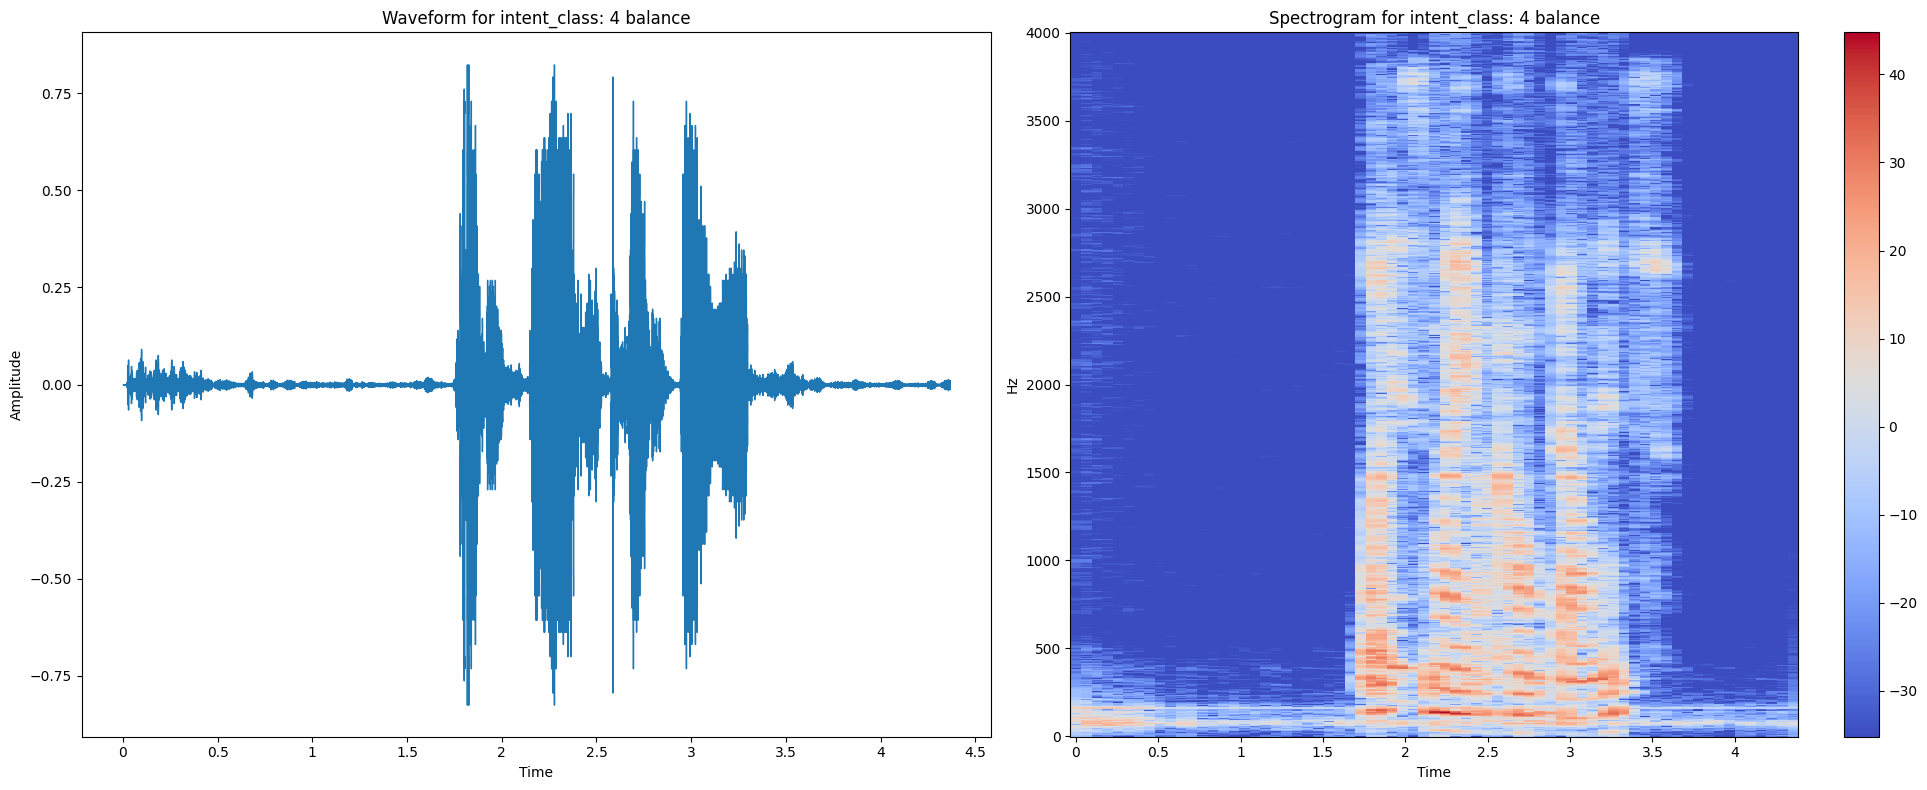

Filter:   0%|          | 0/563 [00:00<?, ? examples/s]

transcription:  I'm calling to inquire about a business loan


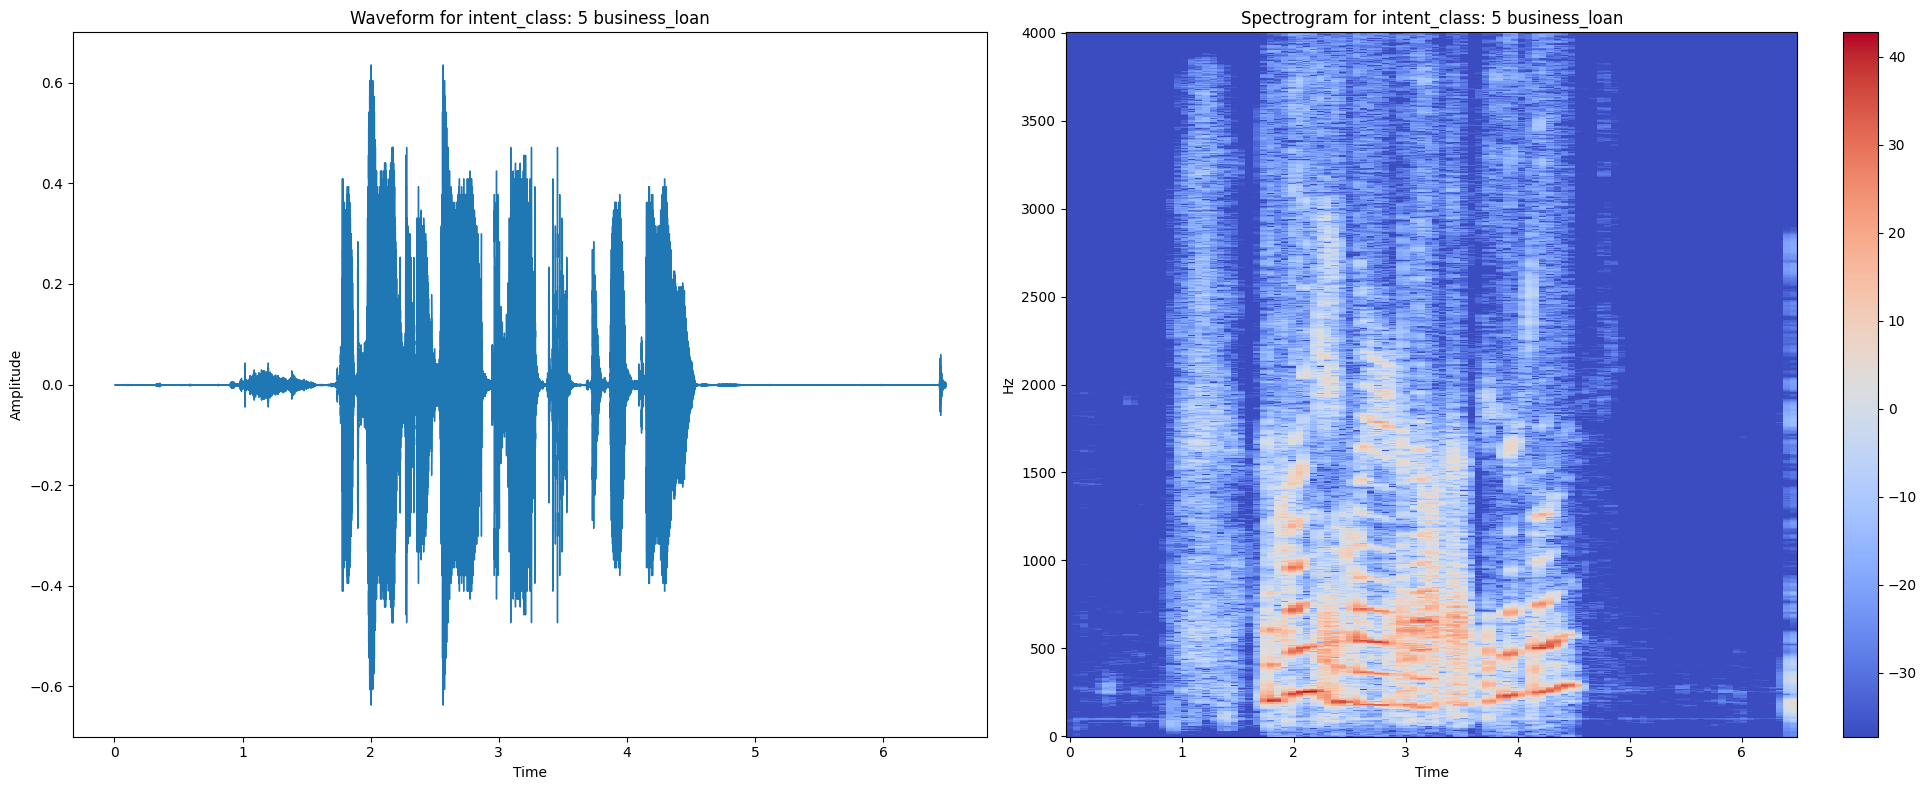

Filter:   0%|          | 0/563 [00:00<?, ? examples/s]

transcription:  I'm trying to say something is my car doesn't seem to work whenever I called do it it doesn't actually work


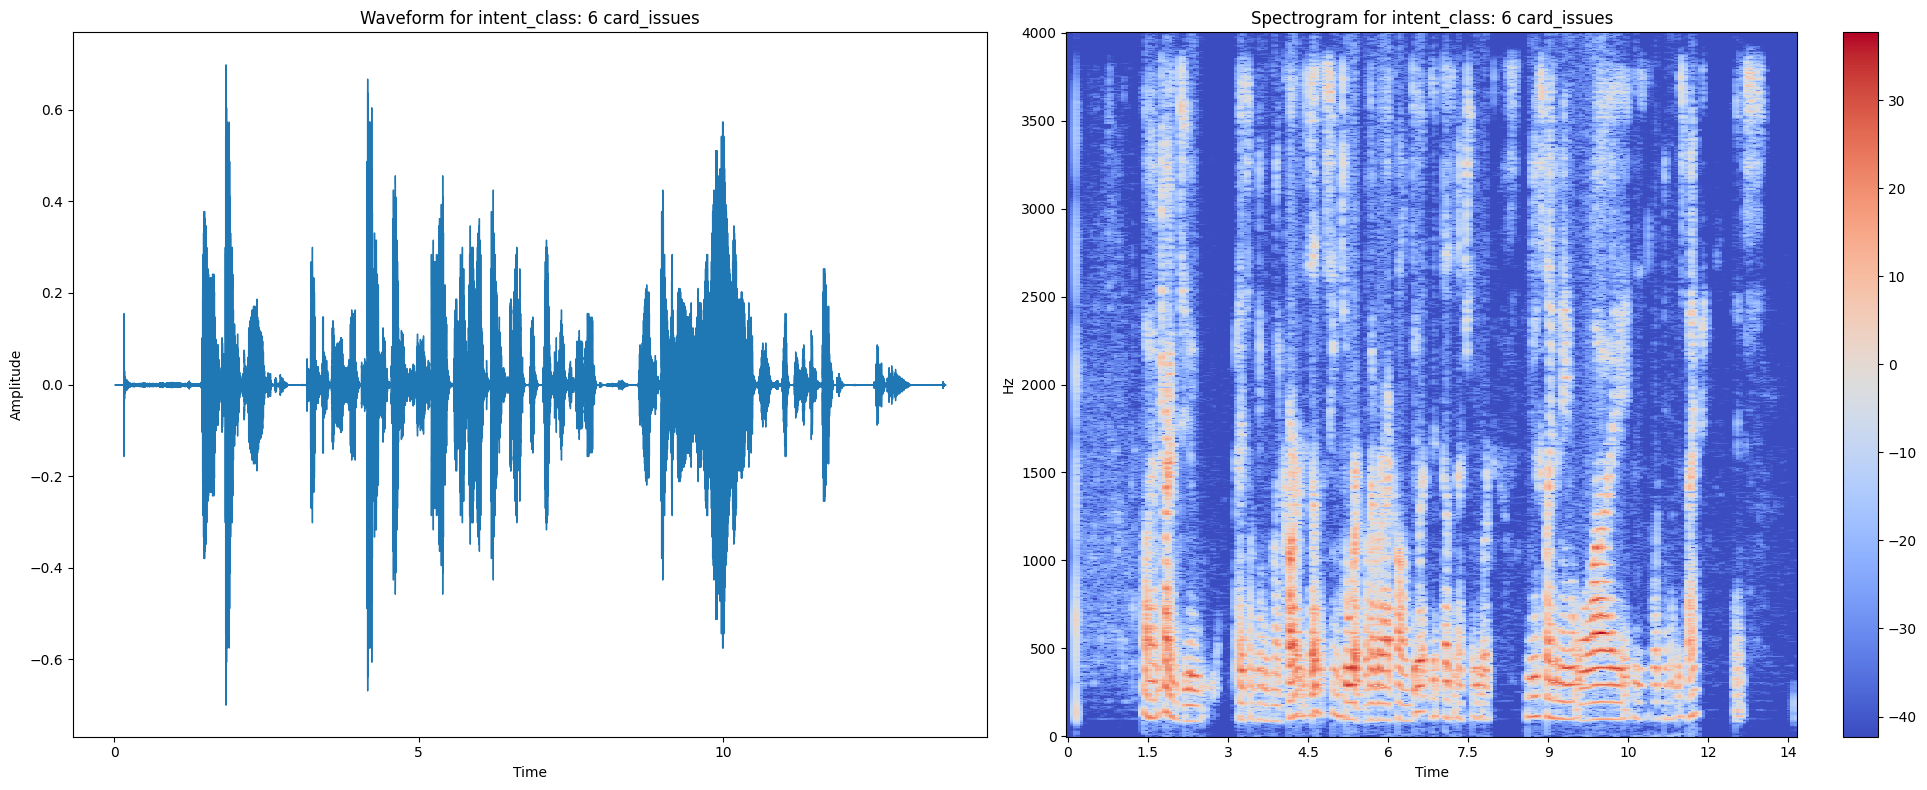

In [ ]:
for intent in range(len(intent_classes)):
  # print(intent)
  # print(intent_classes[intent]['name'])
  plot_waveform_and_spectrogram(minds_enUS, intent, intent_classes[intent]['name'])

In [ ]:
final_dataset = minds_enUS.train_test_split(test_size=0.2)
print("split: ", final_dataset)

final_dataset = final_dataset.remove_columns(
    ["english_transcription",
    "intent_class",
    "lang_id",]
)
print("remove column: ", final_dataset)

print(final_dataset['train']['path'][0])
print(final_dataset['train']['audio'][0]['array'])
print(final_dataset['train']['audio'][0]['sampling_rate'])
print(final_dataset['train']['transcription'][0])

split:  DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 450
    })
    test: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 113
    })
})
remove column:  DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription'],
        num_rows: 450
    })
    test: Dataset({
        features: ['path', 'audio', 'transcription'],
        num_rows: 113
    })
})
/storage/hf-datasets-cache/all/datasets/51125457981586-config-parquet-and-info-PolyAI-minds14-efce24e3/downloads/extracted/cfd42a9443ffb9548ee39e3c64f8b512ca72b9ce5e2ea6b981d44ba6c7265ae8/en-US~ATM_LIMIT/602ba8bdbb1e6d0fbce92109.wav
[0.00024414 0.         0.         ... 0.00097656 0.00097656 0.0012207 ]
8000
I couldn't withdraw money from an ATM for murdering what the max amount I can take out from ATM


In [ ]:
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters(batch):
    batch["transcription"] = re.sub(chars_to_ignore_regex, '', batch["transcription"]).lower() + " "
    batch["transcription"] = batch['transcription'].rstrip()
    return batch

final_dataset = final_dataset.map(remove_special_characters)

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/113 [00:00<?, ? examples/s]

In [ ]:
def extract_all_chars(batch):
  all_text = " ".join(batch["transcription"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

vocabs = final_dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=1,
    keep_in_memory=True,
    remove_columns=final_dataset.column_names['train']
)

vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
print(vocab_dict)

vocab_dict["|"] = vocab_dict[" "]
del vocab_dict [" "]

vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
print(len(vocab_dict))

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/113 [00:00<?, ? examples/s]

{'o': 0, 'f': 1, 'h': 2, 'a': 3, 'c': 4, 'u': 5, 'e': 6, 'k': 7, 'd': 8, ' ': 9, 'r': 10, 'i': 11, 'w': 12, 'n': 13, 'l': 14, 'm': 15, 'x': 16, 't': 17, 's': 18, "'": 19, 'g': 20, 'p': 21, 'y': 22}
25


In [ ]:
from datasets import Audio

final_dataset = final_dataset.cast_column("audio", Audio(sampling_rate=16_000))
final_dataset['train'][0]

{'path': '/storage/hf-datasets-cache/all/datasets/51125457981586-config-parquet-and-info-PolyAI-minds14-efce24e3/downloads/extracted/cfd42a9443ffb9548ee39e3c64f8b512ca72b9ce5e2ea6b981d44ba6c7265ae8/en-US~ATM_LIMIT/602ba8bdbb1e6d0fbce92109.wav',
 'audio': {'path': '602ba8bdbb1e6d0fbce92109.wav',
  'array': array([2.27383804e-04, 1.66404818e-04, 1.76300528e-05, ...,
         1.26234686e-03, 1.18114264e-03, 6.43753330e-04]),
  'sampling_rate': 16000},
 'transcription': "i couldn't withdraw money from an atm for murdering what the max amount i can take out from atm"}

In [ ]:
whisper = 'openai/whisper-tiny'

tokenizer = WhisperTokenizer.from_pretrained(whisper, language="english")
feature_extractor = WhisperFeatureExtractor.from_pretrained(whisper)
processor = WhisperProcessor(
    feature_extractor=feature_extractor,
    tokenizer=tokenizer,
    )

model = WhisperForConditionalGeneration.from_pretrained(whisper)
model.config.forced_decoder_ids = None

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

In [ ]:
audio_array = final_dataset['train']['audio'][0]['array']
audio_sr = final_dataset['train']['audio'][0]['sampling_rate']
audio_text = final_dataset['train']['transcription'][0]

encoded_input = processor(
    audio_array,
    sampling_rate=audio_sr,
    return_tensors='pt',
).input_features

encoded_label = processor(
    text=audio_text,
    return_tensors='pt',
).input_ids

print("array: ", audio_array)
print("text: ", audio_text)
print("#"*50)
print("feature: ", encoded_input)
print("label: ", encoded_label)

array:  [2.27383804e-04 1.66404818e-04 1.76300528e-05 ... 1.26234686e-03
 1.18114264e-03 6.43753330e-04]
text:  i couldn't withdraw money from an atm for murdering what the max amount i can take out from atm
##################################################
feature:  tensor([[[-0.5409, -0.5409, -0.5409,  ..., -0.5409, -0.5409, -0.5409],
         [-0.5409, -0.5409, -0.5409,  ..., -0.5409, -0.5409, -0.5409],
         [-0.5409, -0.5409, -0.5409,  ..., -0.5409, -0.5409, -0.5409],
         ...,
         [-0.5409, -0.5409, -0.5409,  ..., -0.5409, -0.5409, -0.5409],
         [-0.5409, -0.5409, -0.5409,  ..., -0.5409, -0.5409, -0.5409],
         [-0.5409, -0.5409, -0.5409,  ..., -0.5409, -0.5409, -0.5409]]])
label:  tensor([[50258, 50259, 50363,    72,  2809,   380, 14999,  1460,   490,   364,
         22582,   337,  6568,   278,   437,   264, 11469,  2372,   741,   393,
           747,   484,   490, 22582, 50257]])


In [ ]:
predicted_ids = model.generate(encoded_input)

Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.


In [ ]:
decoded_predict = processor.batch_decode(predicted_ids, skip_special_tokens=True)
decoded_label = processor.batch_decode(encoded_label, skip_special_tokens=True)

print("decoded predict: ", decoded_predict)
print("decoded label: ", decoded_label)

decoded predict:  [" I'd like to withdraw money from an ATM, but I'm wondering what the, what my max amount I can take out from the ATM is."]
decoded label:  ["i couldn't withdraw money from an atm for murdering what the max amount i can take out from atm"]


In [ ]:
def prepare_datasets(batch):
  audio = batch['audio']

  batch = processor(
      audio=audio['array'],
      sampling_rate=audio['sampling_rate'],
      text=batch['transcription'],
  )

  batch['input_length'] = len(audio['array']) / audio['sampling_rate']

  return batch

encoded_datasets = final_dataset.map(
    prepare_datasets,
    remove_columns=final_dataset.column_names['train'],
    num_proc=4,
)

Map (num_proc=4):   0%|          | 0/450 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/113 [00:00<?, ? examples/s]

In [ ]:
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_features = [
            {"input_features": feature["input_features"][0]} for feature in features
        ]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        label_features = [{"input_ids": feature["labels"]} for feature in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )

        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [ ]:
metric_wer = evaluate.load("wer")

In [ ]:
from transformers.models.whisper.english_normalizer import BasicTextNormalizer
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
# from nltk.translate import rouge_score
from rouge import Rouge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score, r2_score

normalizer = BasicTextNormalizer()
smoother = SmoothingFunction()

rouge_score = Rouge()

def compute_f1(preds, labels):
    # Convert predictions and labels to binary (0 or 1)
    preds_binary = [1 if p == l else 0 for p, l in zip(preds, labels)]
    labels_binary = [1 if l != processor.tokenizer.pad_token_id else 0 for l in labels]  # Assuming padding token ID is used for no label

    return f1_score(labels_binary, preds_binary)

def compute_r2(preds, labels):
    return r2_score(labels, preds)

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    # Word Error Rate (WER)
    wer_ortho = 100 * metric_wer.compute(predictions=pred_str, references=label_str)

    # Normalized WER
    pred_str_norm = [normalizer(pred) for pred in pred_str]
    label_str_norm = [normalizer(label) for label in label_str]

    wer = metric_wer.compute(predictions=pred_str_norm, references=label_str_norm)

    # Accuracy
    correct_preds = sum(1 for p, l in zip(pred_str_norm, label_str_norm) if p == l)
    total_preds = len(pred_str_norm)
    accuracy = correct_preds / total_preds

    # ROUGE Metrics
    rouge_scores = rouge_score.get_scores(pred_str_norm, label_str_norm, avg=True)

    # F1 Score, R2,
    # (Assuming you have the necessary functions or metrics for these calculations)
    f1_score = compute_f1(pred_str_norm, label_str_norm)
    r2_score = compute_r2(pred_ids, label_ids)

    # BLEU Score
    references = [[ref.split()] for ref in label_str_norm]
    predictions = [pred.split() for pred in pred_str_norm]
    bleu_score = corpus_bleu(references, predictions, smoothing_function=smoother.method1)

    return {
        "wer_ortho": wer_ortho,
        "wer": wer,
        "accuracy": accuracy,
        "f1_score": f1_score,
        "r2_score": r2_score,
        "bleu_score": bleu_score,
        "Rouge 1 r": rouge_scores['rouge-1']['r'],
        "Rouge 1 p": rouge_scores['rouge-1']['p'],
        "Rouge 1 f": rouge_scores['rouge-1']['f'],
    }

In [ ]:
from functools import partial

model.config.use_cache = False
model.generate = partial(
    model.generate,
    language="english",
    task="transcribe",
    use_cache=True,
)

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-tiny-minds14-english",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    learning_rate=3e-5,
    lr_scheduler_type="constant_with_warmup",
    warmup_steps=100,
    max_steps=1000,
    gradient_checkpointing=True,
    fp16=True,
    fp16_full_eval=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=100,
    eval_steps=100,
    logging_steps=100,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
)

In [ ]:
trainer = Seq2SeqTrainer(
    args= training_args,
    model=model,
    train_dataset=encoded_datasets['train'],
    eval_dataset=encoded_datasets['test'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [ ]:
trainer.train()
saved_model_pt = "whisper-tiny-minds14-en"
trainer.save_model(saved_model_pt)

Step,Training Loss,Validation Loss,Wer Ortho,Wer,Accuracy,F1 Score,R2 Score,Bleu Score,Rouge 1 r,Rouge 1 p,Rouge 1 f
100,0.004900,0.627593,25.078567,0.249698,0.292035,0.452055,0.757418,0.704067,0.915978,0.856202,0.879437
200,0.021700,0.675852,24.952860,0.246683,0.265487,0.419580,0.791497,0.714599,0.886698,0.861545,0.868063
300,0.011900,0.614314,24.638592,0.242461,0.300885,0.462585,0.775660,0.704237,0.894981,0.858822,0.871362
400,0.007800,0.685704,24.198617,0.238239,0.292035,0.452055,0.786955,0.712638,0.888775,0.859506,0.868610
500,0.001300,0.710466,24.512885,0.241858,0.318584,0.483221,0.785897,0.716082,0.896484,0.858896,0.870579
600,0.002600,0.705399,25.581395,0.254524,0.318584,0.483221,0.767487,0.709633,0.895441,0.857624,0.869109
700,0.001900,0.700023,23.318668,0.231001,0.345133,0.513158,0.778783,0.723422,0.903443,0.866266,0.878719
800,0.002100,0.699242,25.267128,0.250302,0.283186,0.441379,0.790896,0.715303,0.875614,0.850477,0.856797
900,0.004800,0.640636,25.141420,0.247286,0.318584,0.483221,0.773531,0.713863,0.885272,0.859728,0.866460
1000,0.003600,0.691381,24.010057,0.237033,0.336283,0.503311,0.825517,0.729017,0.871921,0.853195,0.857323


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}
Some non-default generation parameters are set in the model config. These should go into a G

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!tar -cvzf weights.tar.gz /content/whisper-tiny-minds14-en

tar: Removing leading `/' from member names
/content/whisper-tiny-minds14-en/
/content/whisper-tiny-minds14-en/config.json
/content/whisper-tiny-minds14-en/generation_config.json
/content/whisper-tiny-minds14-en/normalizer.json
/content/whisper-tiny-minds14-en/tokenizer_config.json
/content/whisper-tiny-minds14-en/vocab.json
/content/whisper-tiny-minds14-en/special_tokens_map.json
/content/whisper-tiny-minds14-en/model.safetensors
/content/whisper-tiny-minds14-en/preprocessor_config.json
/content/whisper-tiny-minds14-en/training_args.bin
/content/whisper-tiny-minds14-en/added_tokens.json
/content/whisper-tiny-minds14-en/merges.txt


In [ ]:
!cp /content/weights.tar.gz /content/drive/MyDrive

In [ ]:
audio_file = final_dataset['test']['audio'][0]
target = final_dataset['test']['transcription'][0]
device = "cuda:0" if torch.cuda.is_available() else "cpu"

transcriber = pipeline(
    "automatic-speech-recognition",
    model=saved_model_pt,
    chunk_length_s=30,L
    device=device,
)

prediction = transcriber(
    audio_file,
    batch_size=8,
    return_timestamps=True,
)['chunks']

print("timestamp: ", prediction[0]['timestamp'])
print("predict: ", prediction[0]['text'])
print("target: ", target)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


timestamp:  (0.0, None)
predict:  i'd like to deposit money into my account
target:  i'd like to deposit money into my account
